In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
from openstl.models import SimVP_Model
import config

/Users/apple/git/neuro/OpenSTL/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ContiguousSimVP(torch.nn.Module):
    """Wrapper for SimVP model to ensure contiguous tensors."""
    def __init__(self, **kwargs):
        super().__init__()
        self.model = SimVP_Model(**kwargs)
    
    def forward(self, x):
        if not x.is_contiguous():
            x = x.contiguous()
        output = self.model(x)
        if not output.is_contiguous():
            output = output.contiguous()
        return output

def load_model(model_path, device):
    """Load a trained model."""
    model = ContiguousSimVP(**config.MODEL_CONFIG).to(device)
    
    # Handle different state_dict formats
    state_dict = torch.load(model_path, map_location=device)
    if not any(k.startswith('model.') for k in state_dict.keys()):
        new_state_dict = {}
        for key, value in state_dict.items():
            new_state_dict[f'model.{key}'] = value
        state_dict = new_state_dict
    
    model.load_state_dict(state_dict)
    model.eval()
    return model

device = torch.device('mps' if torch.backends.mps.is_available() else 
                     'cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: mps


In [3]:
print("Loading test data...")
test_data = torch.load(f"{config.DATA_DIR}test_data.pt")
test_frames = test_data['frames'].permute(0, 2, 1, 3, 4)
test_inputs = test_frames[:, :16]
test_targets = test_frames[:, 16:]
test_targets = (test_targets > 0.5).float()

print(f"Test data shape: {test_inputs.shape}")
print(f"Test targets shape: {test_targets.shape}")

Loading test data...
Test data shape: torch.Size([100, 16, 1, 32, 32])
Test targets shape: torch.Size([100, 16, 1, 32, 32])


In [4]:
def evaluate_model_detailed(model, test_inputs, test_targets, model_name):
    """Detailed model evaluation with coordinate extraction."""
    model.eval()
    total_error = 0
    total_samples = 0
    predictions_list = []
    
    with torch.no_grad():
        for i in range(min(100, len(test_inputs))):
            input_seq = test_inputs[i:i+1].to(device)
            target_seq = test_targets[i:i+1].to(device)
            
            pred_seq = model(input_seq)
            if pred_seq.dim() == 4:
                pred_seq = pred_seq.unsqueeze(2)
            
            predictions_list.append(pred_seq[0].cpu())
            
            # Calculate pixel error
            B, T, C, H, W = pred_seq.shape
            for t in range(T):
                pred_frame = pred_seq[0, t, 0]
                target_frame = target_seq[0, t, 0]
                
                # Find predicted position
                pred_flat = pred_frame.flatten()
                if pred_flat.sum() > 0:
                    pred_idx = torch.argmax(pred_flat)
                    pred_y, pred_x = pred_idx // W, pred_idx % W
                else:
                    pred_y, pred_x = H//2, W//2
                
                # Find true position
                true_positions = torch.nonzero(target_frame, as_tuple=False)
                if len(true_positions) > 0:
                    true_y, true_x = true_positions[0].float()
                    
                    error = torch.sqrt((pred_x - true_x)**2 + (pred_y - true_y)**2)
                    total_error += error.item()
                    total_samples += 1
    
    avg_error = total_error / total_samples
    print(f"{model_name}: {avg_error:.3f}px")
    return avg_error, predictions_list


In [5]:
model_files = list(Path(config.MODEL_DIR).glob("*.pth"))
model_files = [f for f in model_files if not f.name.endswith('_checkpoint.pth')]

results = {}
all_predictions = {}

for model_file in model_files:
    model_name = model_file.stem
    try:
        print(f"Evaluating {model_name}...")
        model = load_model(str(model_file), device)
        error, predictions = evaluate_model_detailed(
            model, test_inputs, test_targets, model_name
        )
        results[model_name] = error
        all_predictions[model_name] = predictions[:5]  # Store first 5 predictions
    except Exception as e:
        print(f"Error loading {model_name}: {e}")

# Sort results by performance
sorted_results = sorted(results.items(), key=lambda x: x[1])
print("\n=== Model Ranking ===")
for i, (name, error) in enumerate(sorted_results, 1):
    print(f"{i}. {name}: {error:.3f}px")

Evaluating best_ultra_robust_model...
best_ultra_robust_model: 7.347px
Evaluating best_enhanced_robust_model...
best_enhanced_robust_model: 8.413px
Evaluating best_corrected_model...
best_corrected_model: 8.413px
Evaluating best_improved_v2_model...
best_improved_v2_model: 8.413px
Evaluating best_robust_sharp_model...
best_robust_sharp_model: 8.413px
Evaluating best_robust_duration_model...
best_robust_duration_model: 8.413px
Evaluating best_duration_model...
best_duration_model: 8.413px
Evaluating best_improved_model...
best_improved_model: 8.413px
Evaluating best_robust_simple_model...
best_robust_simple_model: 7.347px

=== Model Ranking ===
1. best_ultra_robust_model: 7.347px
2. best_robust_simple_model: 7.347px
3. best_enhanced_robust_model: 8.413px
4. best_corrected_model: 8.413px
5. best_improved_v2_model: 8.413px
6. best_robust_sharp_model: 8.413px
7. best_robust_duration_model: 8.413px
8. best_duration_model: 8.413px
9. best_improved_model: 8.413px


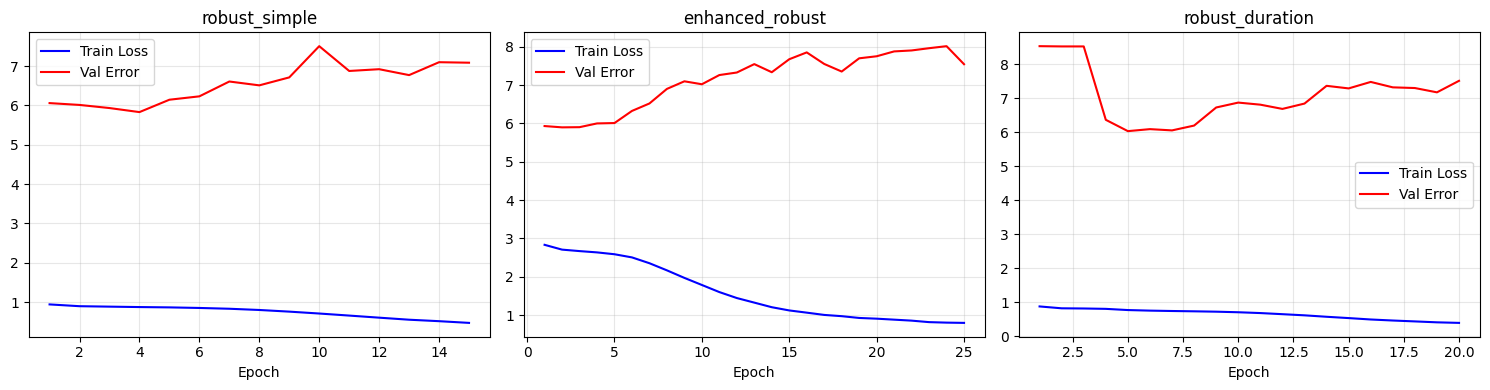

In [6]:
def plot_training_curves():
    """Plot training curves for all models."""
    log_files = list(Path(config.MODEL_DIR).glob("*training_log.txt"))
    
    if not log_files:
        print("No training log files found.")
        return
    
    fig, axes = plt.subplots(1, len(log_files), figsize=(5*len(log_files), 4))
    if len(log_files) == 1:
        axes = [axes]
    
    for i, log_file in enumerate(log_files):
        try:
            df = pd.read_csv(log_file)
            axes[i].plot(df['Epoch'], df['Train_Loss'], 'b-', label='Train Loss')
            axes[i].plot(df['Epoch'], df['Val_Error'], 'r-', label='Val Error')
            axes[i].set_title(log_file.stem.replace('_training_log', ''))
            axes[i].set_xlabel('Epoch')
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
        except Exception as e:
            print(f"Error plotting {log_file}: {e}")
    
    plt.tight_layout()
    plt.show()

plot_training_curves()

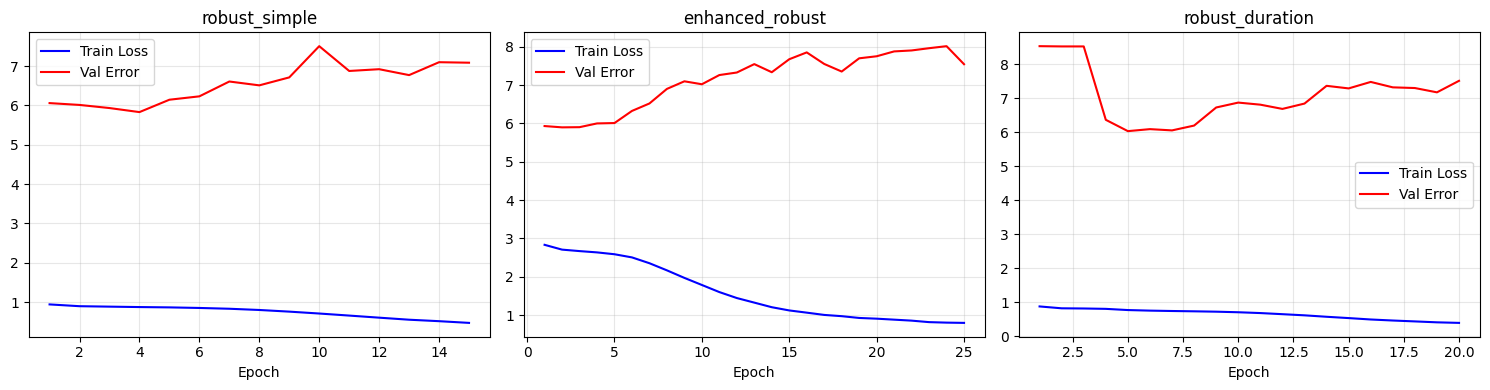

In [7]:
plot_training_curves()

In [8]:
def create_prediction_gif(input_frames, target_frames, pred_frames, 
                         sample_idx, model_name, save_path):
    """Create GIF showing input, target, and predictions."""
    from matplotlib import animation
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    fig.suptitle(f'{model_name} - Sample {sample_idx+1}')
    
    def animate(frame):
        for ax in axes:
            ax.clear()
        
        # Input frame
        axes[0].imshow(input_frames[frame % 16], cmap='gray', vmin=0, vmax=1)
        axes[0].set_title(f'Input Frame {frame % 16 + 1}')
        axes[0].axis('off')
        
        # Target frame
        if frame >= 16:
            target_frame = target_frames[frame - 16]
            axes[1].imshow(target_frame, cmap='gray', vmin=0, vmax=1)
            
            # Find and mark true position
            true_pos = torch.nonzero(target_frame, as_tuple=False)
            if len(true_pos) > 0:
                y, x = true_pos[0]
                axes[1].plot(x, y, 'ro', markersize=8)
        
        axes[1].set_title(f'Target Frame {max(0, frame-15)}')
        axes[1].axis('off')
        
        # Prediction frame
        if frame >= 16:
            pred_frame = pred_frames[frame - 16]
            axes[2].imshow(pred_frame, cmap='gray', vmin=0, vmax=1)
            
            # Find and mark predicted position
            pred_flat = pred_frame.flatten()
            if pred_flat.sum() > 0:
                pred_idx = torch.argmax(pred_flat)
                pred_y, pred_x = pred_idx // 32, pred_idx % 32
                axes[2].plot(pred_x, pred_y, 'ro', markersize=8)
        
        axes[2].set_title(f'Prediction Frame {max(0, frame-15)}')
        axes[2].axis('off')
        
        return []
    
    anim = animation.FuncAnimation(fig, animate, frames=32, interval=250, blit=False)
    anim.save(save_path, writer='pillow', fps=4, dpi=100)
    plt.close(fig)
    print(f"Saved GIF: {save_path}")

# Generate GIFs for best models
Path("results").mkdir(exist_ok=True)
best_models = sorted_results[:3]  # Top 3 models

for model_name, _ in best_models:
    if model_name in all_predictions:
        for sample_idx in range(2):  # First 2 samples
            input_seq = test_inputs[sample_idx]
            target_seq = test_targets[sample_idx]
            pred_seq = all_predictions[model_name][sample_idx]
            
            gif_path = f"results/{model_name}_sample_{sample_idx+1}.gif"
            create_prediction_gif(
                input_seq[:, 0], target_seq[:, 0], pred_seq[:, 0],
                sample_idx, model_name, gif_path
            )

Saved GIF: results/best_ultra_robust_model_sample_1.gif
Saved GIF: results/best_ultra_robust_model_sample_2.gif
Saved GIF: results/best_robust_simple_model_sample_1.gif
Saved GIF: results/best_robust_simple_model_sample_2.gif
Saved GIF: results/best_enhanced_robust_model_sample_1.gif
Saved GIF: results/best_enhanced_robust_model_sample_2.gif


In [9]:
def create_summary_table():
    """Create a summary table of all model results."""
    if not results:
        print("No model results to summarize.")
        return
    
    df = pd.DataFrame(list(results.items()), columns=['Model', 'Pixel_Error'])
    df = df.sort_values('Pixel_Error')
    df['Rank'] = range(1, len(df) + 1)
    df['Improvement_vs_Best'] = ((df['Pixel_Error'] - df['Pixel_Error'].min()) / 
                                df['Pixel_Error'].min() * 100).round(1)
    
    print("=== Final Model Comparison ===")
    print(df.to_string(index=False))
    
    # Save to CSV
    df.to_csv('results/model_comparison.csv', index=False)
    print("\nSaved comparison to results/model_comparison.csv")

create_summary_table()

=== Final Model Comparison ===
                     Model  Pixel_Error  Rank  Improvement_vs_Best
   best_ultra_robust_model     7.347324     1                  0.0
  best_robust_simple_model     7.347324     2                  0.0
best_enhanced_robust_model     8.412950     3                 14.5
      best_corrected_model     8.412950     4                 14.5
    best_improved_v2_model     8.412950     5                 14.5
   best_robust_sharp_model     8.412950     6                 14.5
best_robust_duration_model     8.412950     7                 14.5
       best_duration_model     8.412950     8                 14.5
       best_improved_model     8.412950     9                 14.5

Saved comparison to results/model_comparison.csv


In [10]:
if results:
    best_model_name = min(results.keys(), key=lambda k: results[k])
    best_error = results[best_model_name]
    
    print(f"\n=== Best Model: {best_model_name} ===")
    print(f"Pixel Error: {best_error:.3f}px")
    
    # Load and analyze best model
    best_model_path = f"{config.MODEL_DIR}{best_model_name}.pth"
    best_model = load_model(best_model_path, device)
    
    # Generate additional analysis for best model
    print("Generating detailed analysis for best model...")
    
    # Sample predictions analysis
    with torch.no_grad():
        sample_input = test_inputs[0:1].to(device)
        sample_pred = best_model(sample_input)
        if sample_pred.dim() == 4:
            sample_pred = sample_pred.unsqueeze(2)
        
        pred_stats = {
            'mean_activation': sample_pred.mean().item(),
            'max_activation': sample_pred.max().item(),
            'std_activation': sample_pred.std().item(),
        }
        
        print(f"Prediction statistics: {pred_stats}")



=== Best Model: best_ultra_robust_model ===
Pixel Error: 7.347px
Generating detailed analysis for best model...
Prediction statistics: {'mean_activation': 0.029801059514284134, 'max_activation': 1.8532449007034302, 'std_activation': 0.19116351008415222}
